In [ ]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import wfdb

In [ ]:
import matplotlib.pyplot as plt
import os
import random
import cv2
import io
import shutil
from subprocess import check_output

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from scipy import signal
from scipy.fft import fftshift

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical



In [ ]:
class uniqueRecords:
  def __init__(self, name, record, annotation):
    self.name= name
    self.record= record
    self.annotation= annotation


class allSpectogram:
  def __init__(self, name, image, category):
    self.name=name
    self.image=image
    self.category=category
    


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# file_id = '13Cx6Mi6JPfCAUHqN4aX9LhWGtV3ZLjw-' 
# file_path = f'/content/drive/My Drive/my_apnea_dataset/13Cx6Mi6JPfCAUHqN4aX9LhWGtV3ZLjw-.zip'
path = '/content/drive/MyDrive/my_apnea_dataset/archive (1).zip'

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/content/my_data_folder')
zip_ref.close()


In [ ]:
data_folder= '/content/my_data_folder/apnea-ecg/'

In [ ]:
#filenames=[]
filenames= check_output(["ls", data_folder]).decode("utf8").split('\n')
files= []
for fileName in filenames:
  if fileName.endswith('.apn'):
    fileName = fileName[:3]
    if fileName not in files:
      files.append(fileName)

allRecords = []

for f in files:   
  recordname=data_folder + f
  record = (wfdb.rdsamp(recordname))
  annotation = (wfdb.rdann(recordname, extension= "apn"))

  allRecords.append(uniqueRecords(f,record, annotation))

In [ ]:
len(allRecords)

35

In [ ]:
# defining a function which returns an image as numpy array from figure
def get_img_from_fig(fig, dpi=180):
  fig.canvas.draw()   #drawing the figure first

  #saving into the numpy array
  data= np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data=data.reshape(fig.canvas.get_width_height()[::-1] + (3, ))

  return data


def createSpectogram (allRecords):
  specdetails = []
  for record in allRecords:
    totalparts = len(record.annotation.symbol)
    for i in random.sample(range(totalparts),5):
      fig= plt.figure()
      fig.add_subplot(111)

      NFFT= int(100*0.5)
      Noverlap =  int(100*0.25)

      f, t, Sxx= signal.spectrogram(record.record[0][(i*6000):((i+1)*6000)].flatten(), 100)
      plt.pcolormesh(t, f, Sxx, shading='gouraud')
      plt.axis('off')
      plt.tight_layout()

      plot_img_np= get_img_from_fig(fig)
      plt.close(fig)

      specdetails.append(allSpectogram(record.name, plot_img_np, record.annotation.symbol[i]))
      
  return specdetails


with tf.device(tf.DeviceSpec(device_type='GPU', device_index= '0')):
  allDetails= createSpectogram(allRecords)
   

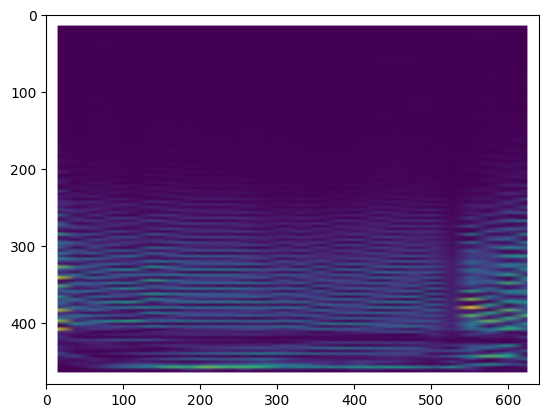

In [ ]:
#allDetails[0].image #plotting the image

plt.imshow(allDetails[0].image)
plt.show()  

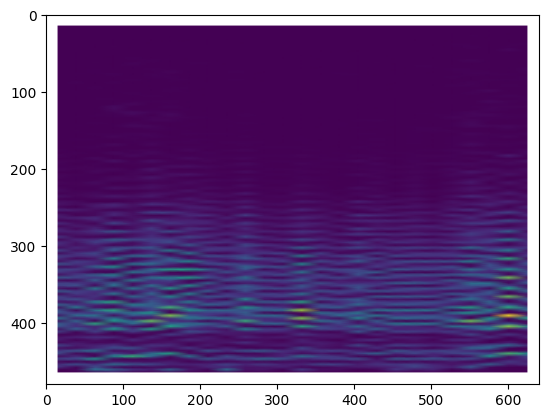

In [ ]:
plt.imshow(allDetails[1].image)
plt.show()

In [ ]:
temp_X=[]
y= []


#image
for a in allDetails:
  img=cv2.cvtColor(a.image,cv2.COLOR_BGR2RGB)  #Convert the input image from one colour space to another
  resize= cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
  temp_X.append(resize)

  y.append(a.category)

  X=np.stack(temp_X)    #joining the seq of array along the same axis
  X=X.astype('float32')

In [ ]:
np.unique(y, return_counts=True)


(array(['A', 'N'], dtype='<U1'), array([ 65, 110]))

In [ ]:
lb= preprocessing.LabelBinarizer()
Y= lb.fit_transform(y) #converting labels to one hot encoding

print("X data shape: ", X.shape)
print("Y data shape: ", Y.shape)

X data shape:  (175, 224, 224, 3)
Y data shape:  (175, 1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split (X, Y, test_size = 0.2, random_state=101)

print("X train data : ", len(x_train))
print("X test data : ", len(x_test))
print("Y train data : ", len(y_train))
print("Y test data : ", len(y_test))


X train data :  140
X test data :  35
Y train data :  140
Y test data :  35


In [ ]:
# index of y_train which has 0 value

y_train_0 =  np.where(y_train==0)
y_train_1 = np.where(y_train==1)

print ("Y train 0 data : ", len(y_train_0[0]))
print ("Y train 1 data : ", len(y_train_1[0]))


Y train 0 data :  55
Y train 1 data :  85


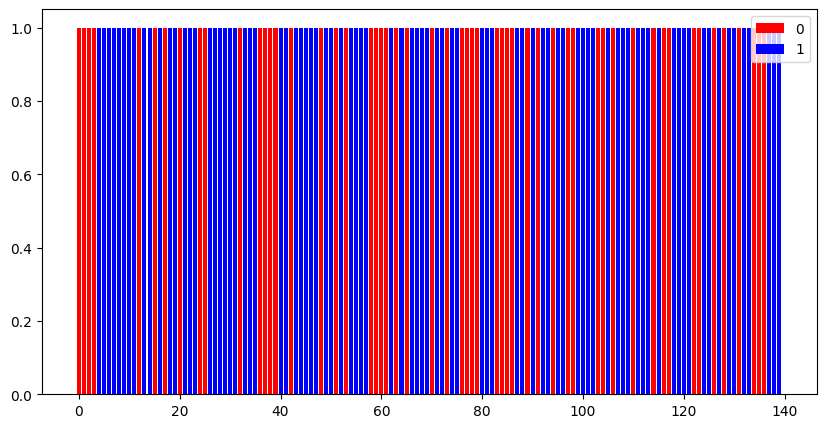

In [ ]:
# bar plot
plt.figure(figsize=(10,5))
# plotting the index graph for apnea and non-apnea

plt.bar(y_train_0[0], np.ones(len(y_train_0[0])), color= 'r', label= '0')
plt.bar(y_train_1[0], np.ones(len(y_train_1[0])), color= 'b', label= '1')

plt.legend()
plt.show()

In [ ]:
lb.inverse_transform(y_train[0])

array(['A'], dtype='<U1')

In [ ]:
y_train[0]

array([0])

In [ ]:
# Saving the data to a folder as the images

if not os.path.exists('./data_images'):
  os.makedirs('./data_images')
else:
   #delete all files and images in the data_images folder

   for file in os.listdir ('./data_images'):
     file_path= os.path.join('./data_images',file)
     if os.path.isfile(file_path):
       os.unlink(file_path)
     elif os.path.isdir(file_path):
       shutil.rmtree(file_path)


# create two folders "train" and "test" in data images folder

if not os.path.exists('./data_images/train'):
  os.makedirs('./data_images/train')
if not os.path.exists('./data_images/test'):
  os.makedirs('./data_images/test')

# in each folder, we are creating a subfolder  for each label ["APNEA","NON-APNEA"]

classes=["APNEA","NON-APNEA"]
for c in classes:
  if not os.path.exists('./data_images/train/'+c):
    os.makedirs('./data_images/train/'+c)
  if not os.path.exists('./data_images/test/'+c):
    os.makedirs('./data_images/test/'+c)

In [ ]:
# loop through x and y and store the images in respective folder

for i in range(len(x_train)):
  if y_train[i][0] == 0:
    cv2.imwrite('./data_images/train/APNEA/'+str(i)+'.png',x_train[i])
  else:
    cv2.imwrite('./data_images/train/NON-APNEA/'+str(i)+'.png',x_train[i])

for i in range(len(x_test)):
  if y_test[i][0] == 0:
    cv2.imwrite('./data_images/test/APNEA/'+str(i)+'.png',x_test[i])
  else:
    cv2.imwrite('./data_images/test/NON-APNEA/'+str(i)+'.png',x_test[i])


In [ ]:
#checking the no. of files in the train and the test folder

base_dir='./data_images/' #base directory
n_classes=2
classes= ['APNEA', 'NON-APNEA']


train_files= sum([len(files) for i, j, files in os.walk(base_dir + "train")])
print ("Total number of samples in the train folder")
print (train_files)

test_files= sum([len(files) for i, j, files in os.walk(base_dir + "test")])
print ("Total number of samples in the test folder")
print (test_files)

print("Total number of files in both train and test folders")
print(train_files+test_files)




Total number of samples in the train folder
140
Total number of samples in the test folder
35
Total number of files in both train and test folders
175


In [ ]:
# Importing the essential libraries and helper for model

import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib
import matplotlib.image as img
import joblib
from tqdm.notebook import tqdm
import random
import collections
from collections import defaultdict
import shutil
from shutil import copy
from shutil import copytree,rmtree

#sklearn imports

from skimage.io import imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import histogram, cumulative_distribution
from scipy.stats import cauchy, logistic
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

#tensorflow imports

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input





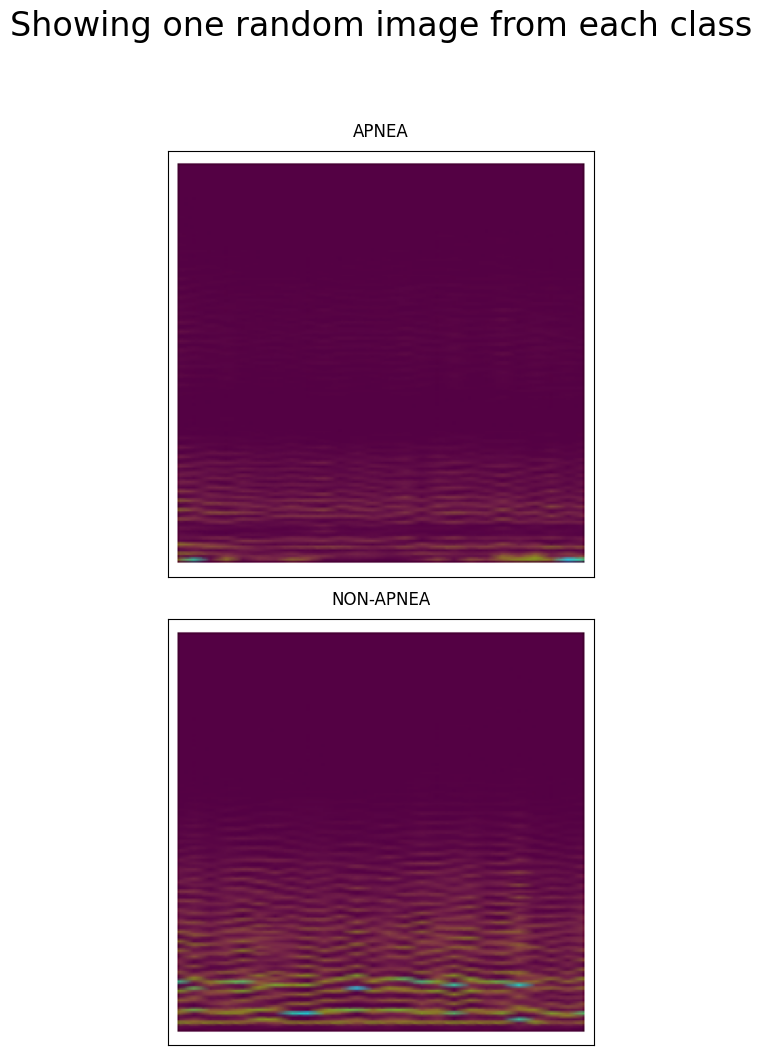

In [ ]:
#Visualizing the data

rows=1
cols=2

fig, ax= plt.subplots(cols, figsize=(10,10))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24)
data_dir= base_dir + "train"
pharyns_sorted = sorted(os.listdir(data_dir))
pharyn_id = 0


for j in range(cols):
  try:
    pharyn_selected = pharyns_sorted[pharyn_id]
    pharyn_id += 1
  except:
    break
  pharyn_selected_images= os.listdir(os.path.join(data_dir,pharyn_selected))
  pharyn_selected_random= np.random.choice(pharyn_selected_images)
  img = cv2.imread(os.path.join(data_dir,pharyn_selected,pharyn_selected_random))
  ax[j].imshow(img, cmap='gray')
  ax[j].set_title(pharyn_selected, pad=10)
  
#set backgroud as white

fig.patch.set_facecolor('white')
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()


In [ ]:


from sklearn.decomposition import PCA
from math import ceil
def eigenimages (full_mat,title, n_comp=0.7, size=(64, 64)):

  pca=PCA(n_components = n_comp, whiten=True)
  pca.fit(full_mat)
  print("Number of PC: ", pca.n_components_)
  return pca

  
def plot_pca(pca, size=(64, 64)):
     #plot eigen images in a grid 
  n=pca.n_components_
  fig=plt.figure(figsize=(8, 8))
  r= int(n**.5)
  c = ceil(n/r)
  fig.patch.set_facecolor("white") 
  for i in range(n):

    ax=fig.add_subplot(r, c, i+1, xticks=[], yticks = []) 
    ax.imshow(pca.components_[i].reshape(size),cmap='Greys_r')

  plt.axis('off')
  plt.show()
   # making n x m matrix
def to_numpy_image(path, list_of_filename, size=(64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = kimage.load_img(fp, target_size=size, color_mode='grayscale')
        img_ts = kimage.img_to_array(current_image) #converts an image to matrix
        img_ts = [img_ts.ravel()]  #turns the image to corresponding vector
        try:
            full_mat = np.concatenate((full_mat, img_ts))   #concatenate different images
        except:
            full_mat = img_ts
    return full_mat


nophar_images=os.listdir(base_dir+ "train/" + classes[1])
phar_images=os.listdir(base_dir+ "/train/" + classes[0])

nophar_images = to_numpy_image (base_dir + "train/NON-APNEA/", nophar_images)
phar_images= to_numpy_image (base_dir + "train/APNEA/", phar_images)


Number of PC:  13


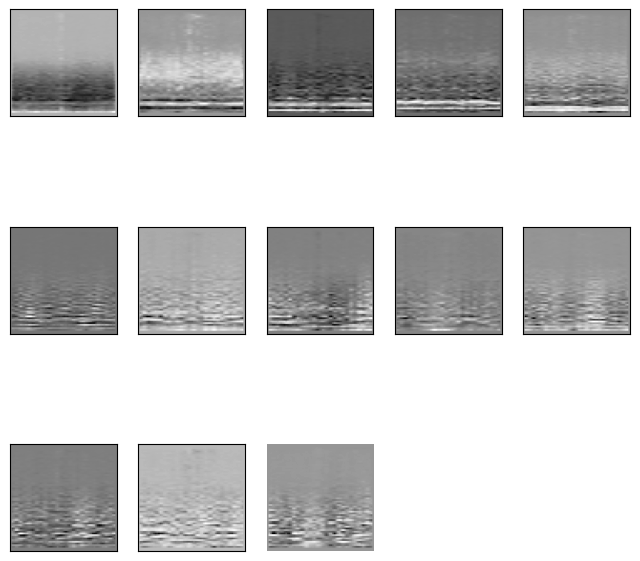

In [ ]:
plot_pca (eigenimages(phar_images, classes[0]))

Number of PC:  13


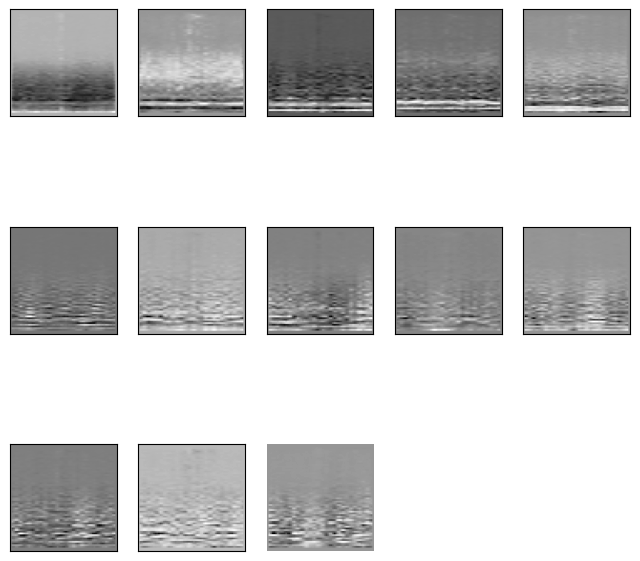

In [ ]:
plot_pca (eigenimages(phar_images, classes[1]))

**Finding the average of apnea images**

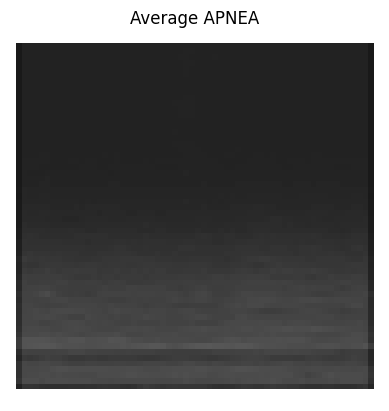

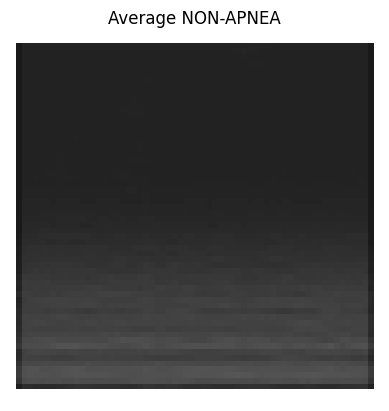

In [ ]:
def find_mean_img(full_mat, title,size=(64,64)):
  mean_img=np.mean(full_mat, axis=0)   #finding the average of images using .mean in numpy array
  mean_img=mean_img.reshape(size)
  plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
  plt.title(f'Average {title}')
  plt.axis('off')
  plt.show()
  return mean_img

phar_mean_img= find_mean_img(phar_images, classes[0])
nophar_mean_img=find_mean_img(nophar_images, classes[1])
                               


**Finding their Contrast images**

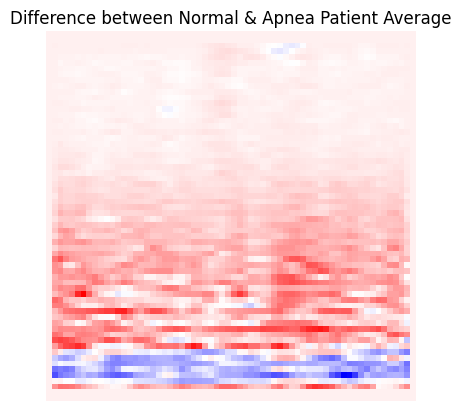

In [ ]:
contrast_mean = phar_mean_img - nophar_mean_img
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference between Normal & Apnea Patient Average')
plt.axis('off')
plt.show()


**Create Data Generators**

In [ ]:
class_mode=""
loss_m=""
last_activation=""
end_num_dense=0
if len(classes)==2:
  class_mode="binary"
  loss_m="binary_crossentropy"
  last_activation="sigmoid"
  end_num_dense=1
elif len(classes) > 2:
  class_mode="categorical"
  loss_m="categorical_crossentropy"
  last_activation="softmax"
  end_num_dense = len(classes)

In [ ]:
train_dir= base_dir + "train"
validation_dir = base_dir + "test"

# creating imageDataGenerator objects for train and test set. Resizing them by div. them with the no. of pixels
train_datagen= ImageDataGenerator(rescale= 1./255)
test_datagen= ImageDataGenerator(rescale= 1./255)

BATCH_SIZE = 5

train_generator = train_datagen.flow_from_directory( train_dir, target_size=(224,224), batch_size= BATCH_SIZE, class_mode= class_mode)
validation_generator = test_datagen.flow_from_directory( validation_dir, target_size=(224,224), batch_size= BATCH_SIZE, class_mode= class_mode)

Found 140 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


**Making of the model**
Creating a Baseline CNN Model from scratch

In [ ]:
end_num_dense

1

In [ ]:
from tensorflow.keras import layers

K.clear_session() #clearing the existing the ram

def build_baseline():
  model= keras.Sequential(
      [
          
          #first convolution layer and max pooling layer
        layers.Conv2D(32, (3,3), activation='relu', padding='same',input_shape=(224,224,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
       
          #second Convolution layer and max pooling
       layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
         # third convolution layer and max-pooling
       layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
       
       # fourth convolution layer and max pooling
       layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
       
       #global average pooling
       layers.GlobalAveragePooling2D(),

       #final dense output layer with sigmoid function
       layers.Dense(end_num_dense, activation=last_activation)
                      
      ])
  

  #compiling the model

  #creating a learning rate for the model
  lr_schedule= keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate= 1e-5,
      decay_steps=100,
      decay_rate=0.9)
# configuring the model with optimisers

  opt=tf.keras.optimizers.Adam(learning_rate= lr_schedule)
  model.compile(loss=loss_m, metrics=['accuracy'], optimizer=opt)

  return model

  

In [ ]:
model=build_baseline()

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

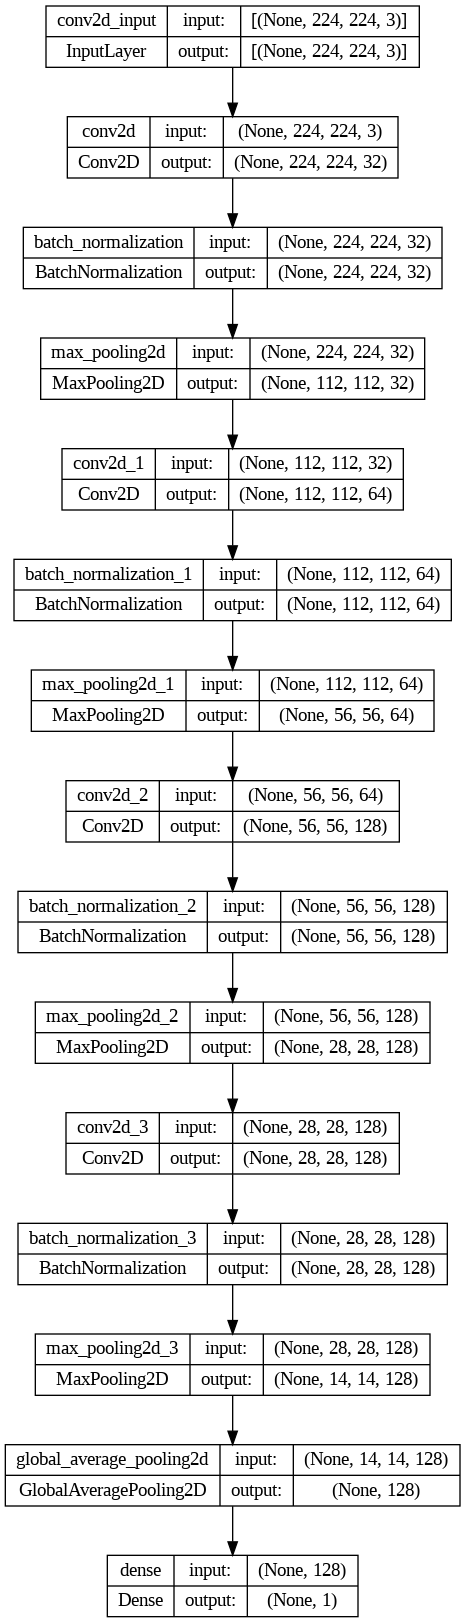

In [ ]:
#create a folder of 'result' if it doesnot exist

if not os.path.exists("./results"):
  os.makedirs("./results")
else:
  print ("Result folder already exists")

tf.keras.utils.plot_model(model, to_file='./results/simple_cnn.png', show_shapes= True)

In [ ]:

K.clear_session()

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config=ConfigProto()
config.gpu_options.allow_growth= True
session= InteractiveSession(config=config)

nb_train_samples=train_files
nb_validation_samples=test_files

bestmodel_path= './models/bestmodel_simple_' + str(n_classes)+ 'class.h5'
trainmodel_path= ' ./models/trainedmodel_simple_' + str(n_classes)+ 'class.h5'
history_path= './results/history_simple_'+ str(n_classes)+'.log'

callback= tf.keras.callbacks.EarlyStopping(monitor= 'val_accuarcy', patience=100, min_delta=1e-3, restore_best_weights= True)

checkpoint= ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only= True)
csv_logger=CSVLogger(history_path)

#start the training
num_epochs= 1000
history=model.fit(train_generator,
                  steps_per_epoch=nb_train_samples //BATCH_SIZE,
                  validation_data=validation_generator,
                  validation_steps=nb_validation_samples // BATCH_SIZE,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=[callback,csv_logger, checkpoint])

model.save("./models/phar-baseline.h5")

Epoch 1/1000
28/28 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5500


Epoch 1: val_loss improved from inf to 0.70954, saving model to ./models/bestmodel_simple_2class.h5
28/28 [==============================] - 26s 817ms/step - loss: 0.6892 - accuracy: 0.5500 - val_loss: 0.7095 - val_accuracy: 0.2857
Epoch 2/1000
28/28 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.6143


Epoch 2: val_loss did not improve from 0.70954
28/28 [==============================] - 23s 832ms/step - loss: 0.6632 - accuracy: 0.6143 - val_loss: 0.7327 - val_accuracy: 0.2857
Epoch 3/1000
28/28 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.6214


Epoch 3: val_loss did not improve from 0.70954
28/28 [==============================] - 22s 802ms/step - loss: 0.6531 - accuracy: 0.6214 - val_loss: 0.7667 - val_accuracy: 0.2857
Epoch 4/1000
28/28 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.6214


Epoch 4: val_loss did not improve from 0.70954
28/28 [==============================] - 23s 807ms/step - loss: 0.6490 - accuracy: 0.6214 - val_loss: 0.8129 - val_accuracy: 0.2857
Epoch 5/1000
 9/28 [========>.....................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5778

KeyboardInterrupt: ignored

In [ ]:
#getting train and validation accuracies
train_acc_CNN = history.history ['accuracy']
val_acc_CNN = history.history ['val_accuracy']
 #getting train and validation Losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history[ 'val_loss']
epochs = range(1, len(train_loss_CNN)+1)
#plotting the training and validation occurracies
plt.figure()
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r' ,label= 'validation acc')
plt.title( 'training and validation accuracy for CNN')
plt.legend()
 #plotting the train and validation Losses
plt.figure()
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN,'r',label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()
plt.show()

**Building CNN Model from sctrach**

In [ ]:
#instantiate a basic Densenet121 model whch has been trained on Imagenet dataset
from tensorflow.keras.applications import DenseNet121
conv_base = DenseNet121(weights= 'imagenet',
include_top=False,
input_shape=(224, 224, 3))
#freeze the weight of the convolutional base
conv_base.trainable=False
#get the summary of the model to view SCF architecture
conv_base.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

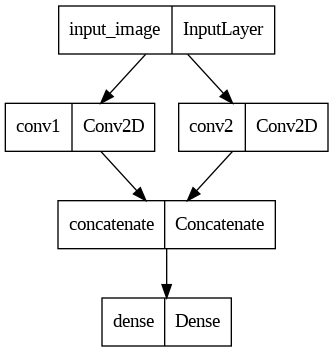

In [ ]:
#create a hypothetical non-Linear model to illustrate functional API
#create on input Layer/tensor
input= layers.Input(shape=(224, 224, 3), dtype="float32", name= "input_image")
#create two convolutional Layers with different filter sizes taking the same input tensor
conv1=layers.Conv2D(128, (5, 5), padding= "same" ,activation= 'relu',name="conv1")(input)
conv2=layers.Conv2D(128, (3, 3), padding= "same",activation= 'relu', name="conv2")(input)
 #concatenate the output of the two convolution Layers
concat=layers.concatenate([conv1, conv2], axis=-1)
 #create the dense Layer that takes the concatenated output
output_dense=layers.Dense(10, activation=last_activation)(concat)
#create a model that cakes the input tensor as input and gives the output of the dense layer as output
hypothetical_model=Model(input, output_dense)
#plot the model
tf.keras.utils.plot_model(hypothetical_model)

In [ ]:
#initialize the topclassifier to the output of the convolutional base of densenet
topClassifier=conv_base.output


#Adding the global average pooLing (GAP)Layer on top of conv_base
topClassifier=layers.GlobalAveragePooling2D()(topClassifier)

#adding 0 dense layer on top of GAP Layer to do the classification
topClassifier=layers.Dense(end_num_dense, activation=last_activation)(topClassifier)
model=Model(inputs=conv_base.input, outputs=topClassifier)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
train_dir= base_dir + './train'
validation_dir=base_dir + './test'

BATCH_SIZE=5
a_n= False   #if augmentation of data is needed

if a_n:
  #re-define the train_datagen with data augmentation
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,               
    horizontal_flip=True)

  validation_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True )
else:
  train_datagen = ImageDataGenerator(rescale=1./255)
  validation_datagen = ImageDataGenerator(rescale=1./255)




train_generator = train_datagen.flow_from_directory( train_dir, target_size=(224,224), batch_size= BATCH_SIZE, class_mode= class_mode)
validation_generator = test_datagen.flow_from_directory( validation_dir, target_size=(224,224), batch_size= BATCH_SIZE, class_mode= class_mode)










In [ ]:
#creating the learning schedule for the model
lr_schedule= keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate= 1e-3,
      decay_steps=50,
      decay_rate=0.9)

# configuring the model with optimisers

opt=tf.keras.optimizers.Adam(learning_rate= lr_schedule)
model.compile(loss=loss_m, metrics=['accuracy'], optimizer=opt)


bestmodel_path= './models/bestmodel_transfer_' + str(n_classes)+ 'class.h5'
trainedmodel_path= ' ./models/trainedmodel_transfer_' + str(n_classes)+ 'class.h5'
history_path= './results/history_transfer_'+ str(n_classes)+'.log'

callback= tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', patience=100, min_delta=1e-3, restore_best_weights= True)

checkpoint= ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only= True)
csv_logger=CSVLogger(history_path)



#start the training
num_epochs= 1000
history=model.fit(train_generator,
                  steps_per_epoch=nb_train_samples //BATCH_SIZE,
                  validation_data=validation_generator,
                  validation_steps=nb_validation_samples // BATCH_SIZE,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=[callback,csv_logger, checkpoint])



In [ ]:
#getting train and validation accuracies
train_acc_CNN = history.history ['accuracy']
val_acc_CNN = history.history ['val_accuracy']


 #getting train and validation Losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history[ 'val_loss']
epochs = range(1, len(train_loss_CNN)+1)


#plotting the training and validation occurracies

plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r' ,label= 'validation acc')
plt.title( 'training and validation accuracy for CNN')
plt.legend()
plt.figure()


 #plotting the train and validation Losses

plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN,'r',label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()


plt.show()

**Fine Tuning the model for better accuarcy**

In [ ]:
#unfreeze the convolutional base layer
conv_base.trainable = True


#set the trainable to False for all alyers except the last 9 layers, i.e freeze their weights

for layer in conv_base.layers[:9]:
  layer.trainable = False

#set the trainable to False for all layers except the last 9 layers(LAST CONVOLUTION BLOCK IN DENSENET-21), i.e freeze their weights
for layer in conv_base.layers[:9]:
  layer.trainable = True

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
callback= tf.keras.callbacks.EarlyStopping(monitor= 'val_accuracy', patience=50, min_delta=1e-3, restore_best_weights= True)


model.compile(loss=loss_m, metrics=['accuracy'], optimizer=opt)



bestmodel_path= './models/bestmodel_transfer_tuned_' + str(n_classes)+ 'class.h5'
trainedmodel_path= ' ./models/trainedmodel_transfer_tuned_' + str(n_classes)+ 'class.h5'
history_path= './results/history_transfer_tuned'+ str(n_classes)+'.log'



checkpoint= ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only= True)
csv_logger=CSVLogger(history_path)



#start the training
num_epochs= 1000
history=model.fit(train_generator,
                  steps_per_epoch=nb_train_samples //BATCH_SIZE,
                  validation_data=validation_generator,
                  validation_steps=nb_validation_samples // BATCH_SIZE,
                  epochs=num_epochs,
                  verbose=1,
                  callbacks=[callback,csv_logger, checkpoint])

In [ ]:
if a_n:
  model =  load_model('./models/bestmodel_simple_augmented_'+str(n_classes)+'class.h5')
else:
  model = load_model('./models/bestmodel_simple_'+str(n_classes)+'class.h5')

In [ ]:
test_dir= base_dir + './test'

#read the test images using ImageDataGenerator

test_datagen= ImageDataGenerator(rescale =1./255)
test_generator= test_datagen.flow_from_directory( test_dir, target_size=(224, 224), batch_size=20, class_mode=class_mode)


#computer the loss and accuracy on the test set using model.evaluate method
test_loss, test_acc = model.evauate(test_generator, steps=50)
print('test_acc:', test_acc)

Computing the accuracy on the test data

**BASELINE MODEL EVALUTAION**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import datasets,metrics

predicted=[]
actuals=[]

if n_classes>2:
   batch_index=0
   for x,y in validation_generator:
       if batch_index>10:
           break;
       y_pred =  model.predict(x)
       y_pred_label= np.argmax(y_pred, axis=1)
       actual = np.argmax(y, axis=1)

       for x in actual:actuals.append(x)
       for x in y_pred_label:predicted.append(x)
       batch_index+=1

if n_classes==2:
   batch_index=0
   for x,y in validation_generator:
     if batch_index> 10:
         break;
     y_pred =  model.predict(x)
     for x in y_pred:predicted.append(x[0])
     for x in y:actuals.append(x)
     batch_index+=1
       

   for i in range(len(predicted)):
       if predicted[i]>0.5:
           predicted[i]=1
       else:
           predicted[i]=0


print(classification_report(actuals, predicted)) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools



def plot_cm(cm, target_names, title='Confusion Matrix',cmap=None, normalize=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
       cmap= plt.get_cmap('Blues')

    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tile(title)
    plt.colorbar()

    if target_names is not None:
       tick_marks = np.arange(len(target_names))
       plt.xticks(tick_marks, target_names, rotation=45)
       plt.yticks(tick_marks, target_names)

    if normalize:
       cm =cm.astype('float') /  cm.sum(axis=1)[:, np.newaxis]

    thresh= cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuarcy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


target_names =  classes
cf= confusion_matrix(actuals, predicted)
plot_cm(cf, target_names)

In [ ]:
nb_validation_samples = test_files

#create a dictionary for label names.
dd = os.listdir(base_dir + './train')
dd = sorted(dd)
names = {}
for i, name in enumerate(dd):
    names[i] = name

print(names)

batch_index = 0
# set each batch of images in the validation generator (x is the image, y is its true Label)
for x, y in validation_generator:
    if batch_index > 5:
        break;

    try:

        if n_classes > 2:
            # Get the predicted probabilities for the images in the batch. It will return a numpy array of size 1'batch_size
            y_pred = model.predict(x).flatten()
            preds2 = y_pred.reshape(BATCH_SIZE, n_classes)
            y_pred_label = np.argmax(preds2, axis=1)
            actuals = np.argmax(y, axis=1)

            # If a predicted probability for an image is se.5, set the predicted Label to otherwise to zero y_pred Label-np.where(y_predse.5, 1.,0.)
            # get the indices of the misclassified images in the batch
            errors = np.where(y_pred_label != actuals)[0]

            # display the misclassified images together with their predicted probabilities
            for i in errors:
                print(y_pred_label[i], actuals[i])
                print("True label is: {}, CNN predicted {}".format(names[actuals[i]], names[y_pred_label[i]]))
                plt.imshow(x[i])
                plt.show()
        else:
            y_pred = model.predict(x)
            y_pred_label = []
            for pred in y_pred:
                if pred[0] > 0.5:
                    y_pred_label.append(1)
                else:
                    y_pred_label.append(0)

            actuals = y
            errors = np.where(y_pred_label != actuals)[0]

            for i in errors:
                print(y_pred_label[i], actuals[i])
                print('True Label is: {}, CNN predicted {}'.format(names[actuals[i]], names[y_pred_label[i]]))
                plt.imshow(x[i])
                plt.show()

    except:
        pass

    batch_index += 1